<center><img src="https://i.imgur.com/zRrFdsf.png" width="700"></center>
<a target="_blank" href="https://colab.research.google.com/github/CienciaDeDatosEspacial/GDF_OPS_applications/blob/main/gasandschools.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# Moving Gas Stations away from Schools in Seattle, WA
# By: Alejandra Budiel - 20232059

# Getting ready

## Installations needed

In [298]:

!pip install osmnx mapclassify

## Data needed

### Official data preprocessing

In [299]:
import geopandas as gpd

filez="https://github.com/20232059/PC2/raw/refs/heads/main/2020_Census_Tracts_Seattle_8661193084158732132.zip"
seattle=gpd.read_file(filez)
seattle.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   GEOID20     177 non-null    object  
 1   GROSS_ACRE  177 non-null    float64 
 2   LAND_ACRES  177 non-null    float64 
 3   WATER_ACRE  177 non-null    float64 
 4   NAME        177 non-null    object  
 5   TRACT_NUMB  177 non-null    int64   
 6   BASENAME    177 non-null    object  
 7   UVDA_AREA   177 non-null    object  
 8   CRA_NO      177 non-null    float64 
 9   CRA_GRP     177 non-null    int32   
 10  GEN_ALIAS   177 non-null    object  
 11  DETL_NAMES  177 non-null    object  
 12  C_DISTRICT  177 non-null    int64   
 13  geometry    177 non-null    geometry
dtypes: float64(4), geometry(1), int32(1), int64(2), object(6)
memory usage: 18.8+ KB


As you see, it is just one geometry:

In [300]:

seattle

,GEOID20,GROSS_ACRE,LAND_ACRES,WATER_ACRE,NAME,TRACT_NUMB,BASENAME,UVDA_AREA,CRA_NO,CRA_GRP,GEN_ALIAS,DETL_NAMES,C_DISTRICT,geometry
0,53033000402,444.493643,444.527261,0.000000,Census Tract 4.02,402,4.02,Bitter Lake Village,9.1,9,Broadview/Bitter Lake,"Broadview, Bitter Lake",5,"POLYGON ((1267598.433 267477.138, 1267788.924 ..."
1,53033000403,180.930716,165.408389,15.535762,Census Tract 4.03,403,4.03,Bitter Lake Village,9.1,9,Broadview/Bitter Lake,"Broadview, Bitter Lake",5,"POLYGON ((1265848.993 271492.767, 1265842.812 ..."
2,53033000700,319.838996,319.862596,0.000000,Census Tract 7,700,7,Lake City,8.2,8,Olympic Hills/Victory Heights,"Lake City, Victory Heights, Olympic Hills, Pin...",5,"POLYGON ((1277629.018 265876.292, 1277833.975 ..."
3,53033003302,154.942826,154.952619,0.000000,Census Tract 33.02,3302,33.02,Ballard,10.2,10,Whittier Heights,"Whittier Heights, Loyal Heights, Crown Hill",6,"POLYGON ((1262877.612 251639.607, 1262891.039 ..."
4,53033003601,166.571397,166.583375,0.000000,Census Tract 36.01,3601,36.01,Green Lake - Roosevelt,9.4,9,Green Lake,"Green Lake, Meridian, Roosevelt, Woodland Park",6,"POLYGON ((1274839.167 250046.877, 1274833.189 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,53033008101,68.690415,66.798515,68.613998,Census Tract 81.01,8101,81.01,Center City,13.2,13,Downtown Commercial Core,"Downtown Commercial Core, West Edge, Central B...",7,"POLYGON ((1268688.847 226501.062, 1268841.791 ..."
173,53033010401,402.739919,402.750637,0.000000,Census Tract 104.01,10401,104.01,Othello,3.5,3,Beacon Hill,Beacon Hill,2,"POLYGON ((1279994.827 207985.661, 1280136.282 ..."
174,53033011401,304.713408,304.719237,0.000000,Census Tract 114.01,11401,114.01,Westwood-Highland Park,2.4,2,Roxhill/Westwood,"Roxhill, Westwood, South Delridge, White Center",1,"POLYGON ((1264535.644 198387.214, 1264519.606 ..."
175,53033011700,868.762098,868.775078,0.000000,Census Tract 117,11700,117,Rainier Beach,3.4,3,South Beacon Hill/NewHolly,"South Beacon Hill, NewHolly, Holly Park",2,"POLYGON ((1280795.738 197846.082, 1280877.933 ..."


The map we have has come projected:

In [301]:

seattle.crs

<Projected CRS: PROJCS["NAD83(HARN) / Washington North (ftUS)",GEO ...>
Name: NAD83(HARN) / Washington North (ftUS)
Axis Info [cartesian]:
- [east]: Easting (US survey foot)
- [north]: Northing (US survey foot)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Lambert Conic Conformal (2SP)
Datum: NAD83 (High Accuracy Reference Network)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

### Crowdsourced data pre processing

Now we need the schools and gas stations. Let's become familiar with OpenStreet Maps [API for Python](https://osmnx.readthedocs.io/en/stable/), which for our case would be very useful.

You can get the gas stations from Seattle like this:


In [302]:

# Get gas stations in Boston
import osmnx as ox

stations = ox.features_from_place("Seattle, Washington, USA",
                                tags={'amenity': 'fuel'})

Notice we are getting several gas stations, already as a GDF:

In [303]:
stations.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 129 entries, ('node', np.int64(457773031)) to ('way', np.int64(1106778201))
Data columns (total 70 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   geometry                   129 non-null    geometry
 1   amenity                    129 non-null    object  
 2   brand                      112 non-null    object  
 3   brand:wikidata             110 non-null    object  
 4   name                       120 non-null    object  
 5   addr:city                  42 non-null     object  
 6   addr:housenumber           46 non-null     object  
 7   addr:postcode              43 non-null     object  
 8   addr:street                46 non-null     object  
 9   check_date                 47 non-null     object  
 10  compressed_air             49 non-null     object  
 11  website                    33 non-null     object  
 12  source                     79 

OSM gave you stations unprojected:

In [304]:
stations.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Notice the multi-index:

In [305]:
stations

geometry amenity  \
element id                                                                      
node    457773031                         POINT (-122.39997 47.63939)    fuel   
        631386821                          POINT (-122.3203 47.62518)    fuel   
        678256779                         POINT (-122.29762 47.57811)    fuel   
        771801423                         POINT (-122.35525 47.73205)    fuel   
        1197964284                        POINT (-122.32958 47.58001)    fuel   
...                                                               ...     ...   
way     616232166   POLYGON ((-122.29764 47.57818, -122.29764 47.5...    fuel   
        616232167   POLYGON ((-122.29757 47.57809, -122.29749 47.5...    fuel   
        727276570   POLYGON ((-122.33603 47.53219, -122.33603 47.5...    fuel   
        940949039   POLYGON ((-122.26383 47.68144, -122.26394 47.6...    fuel   
        1106778201  POLYGON ((-122.30916 47.57672, -122.30956 47.5...    fuel   

                       brand brand:wikidata              name addr:city  \
element id                                                                
node    457773031    Chevron        Q319642  Magnolia Chevron       NaN   
        631386821         76       Q1658320                76   Seattle   
        678256779       Arco        Q304769              Arco       NaN   
        771801423    Chevron        Q319642           Chevron       NaN   
        1197964284     Shell     Q110716465             Shell       NaN   
...                      ...            ...               ...       ...   
way     616232166        NaN            NaN               NaN       NaN   
        616232167        NaN            NaN               NaN       NaN   
        727276570      Shell     Q110716465           Shree's   Seattle   
        940949039   7-Eleven        Q259340          7-Eleven       NaN   
        1106778201  Sinclair            NaN               NaN       NaN   

                   addr:housenumber addr:postcode              addr:street  \
element id                                                                   
node    457773031               NaN           NaN                      NaN   
        631386821               915         98102          East Roy Street   
        678256779               NaN           NaN                      NaN   
        771801423               NaN           NaN                      NaN   
        1197964284              NaN           NaN                      NaN   
...                             ...           ...                      ...   
way     616232166               NaN           NaN                      NaN   
        616232167               NaN           NaN                      NaN   
        727276570               140         98106  Southwest Kenyon Street   
        940949039               NaN           NaN                      NaN   
        1106778201              NaN           NaN                      NaN   

                    check_date  ... contact:facebook contact:instagram  \
element id                      ...                                      
node    457773031          NaN  ...              NaN               NaN   
        631386821   2024-08-13  ...              NaN               NaN   
        678256779          NaN  ...              NaN               NaN   
        771801423          NaN  ...              NaN               NaN   
        1197964284         NaN  ...              NaN               NaN   
...                        ...  ...              ...               ...   
way     616232166          NaN  ...              NaN               NaN   
        616232167          NaN  ...              NaN               NaN   
        727276570          NaN  ...              NaN               NaN   
        940949039          NaN  ...              NaN               NaN   
        1106778201         NaN  ...              NaN               NaN   

                   contact:phone contact:twitter cont

In the multi index you see **nodes**, **relations**, and **ways**:

In [306]:
stations.index

MultiIndex([('node',  457773031),
            ('node',  631386821),
            ('node',  678256779),
            ('node',  771801423),
            ('node', 1197964284),
            ('node', 1489962206),
            ('node', 1731281907),
            ('node', 2702032640),
            ('node', 2702054487),
            ('node', 2995124967),
            ...
            ( 'way',  600101678),
            ( 'way',  600101691),
            ( 'way',  600101760),
            ( 'way',  603557992),
            ( 'way',  616232144),
            ( 'way',  616232166),
            ( 'way',  616232167),
            ( 'way',  727276570),
            ( 'way',  940949039),
            ( 'way', 1106778201)],
           names=['element', 'id'], length=129)

Some formatting may be needed at this stage:

- This will put current indexes back into the data, and numbers will appear:

In [307]:
stations.reset_index(drop=False,inplace=True)
stations.head()

,element,id,geometry,amenity,brand,brand:wikidata,name,addr:city,addr:housenumber,addr:postcode,...,contact:facebook,contact:instagram,contact:phone,contact:twitter,contact:youtube,covered,shop,landuse,contact:website,mapwithai:source
0,node,457773031,POINT (-122.39997 47.63939),fuel,Chevron,Q319642,Magnolia Chevron,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,node,631386821,POINT (-122.3203 47.62518),fuel,76,Q1658320,76,Seattle,915,98102,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,node,678256779,POINT (-122.29762 47.57811),fuel,Arco,Q304769,Arco,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,node,771801423,POINT (-122.35525 47.73205),fuel,Chevron,Q319642,Chevron,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,node,1197964284,POINT (-122.32958 47.58001),fuel,Shell,Q110716465,Shell,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Keep some columns:

In [308]:
colsToKeep=['element','name','geometry']

fuelSeattle=stations[colsToKeep].copy()

- Reproject the data:

In [309]:

Seattle_crs = "EPSG:26910"

fuelSeattle = fuelSeattle.to_crs(Seattle_crs)

- Review:

In [310]:

fuelSeattle.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   element   129 non-null    object  
 1   name      120 non-null    object  
 2   geometry  129 non-null    geometry
dtypes: geometry(1), object(2)
memory usage: 3.2+ KB


- From above, columns **name** of the gas station has missing values. We should rename those missing values:

In [313]:


fuelSeattle.fillna({'name':'Unknown'},inplace=True)

- We usually use the names as row index. But row index should not have duplicates. Since several 'names' are the same (_Unknown_), we have to create new names:

In [314]:

fuelSeattle.index.astype(str)+"_"+fuelSeattle.name

,0
0,0_Magnolia Chevron
1,1_76
2,2_Arco
3,3_Chevron
4,4_Shell
...,...
124,124_Unknown
125,125_Unknown
126,126_Shree's
127,127_7-Eleven


Let's reformat this as we did before:

See element vs geo:

Then,

In [315]:
fuelSeattle['newname']=fuelSeattle.index.astype(str)+"_"+fuelSeattle['name']
fuelSeattle.set_index('newname',inplace=True)
fuelSeattle.drop(columns=['name'],inplace=True)
fuelSeattle.head()

,element,geometry
newname,,
0_Magnolia Chevron,node,POINT (545070.577 5276395.041)
1_76,node,POINT (551068.412 5274865.552)
2_Arco,node,POINT (552820.393 5269650.118)
3_Chevron,node,POINT (548343.649 5286720.849)
4_Shell,node,POINT (550414.847 5269839.108)


See that **nodes** are points, **ways** are lines or simple shapes built from points, and **relations** are conceptual containers that group any of the other elements to represent complex features.

Let me compare with the geometries available:


In [316]:
import pandas as pd

pd.crosstab(fuelSeattle.element,fuelSeattle.geometry.geom_type, margins=True)

col_0,Point,Polygon,All
element,,,
node,15,0,15
way,0,114,114
All,15,114,129


Getting the schools:

In [317]:
# Get schools in Seattle
schools = ox.features_from_place("Seattle, Washington, USA",
                                tags={'amenity': 'school'})
schools.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 210 entries, ('node', np.int64(356540545)) to ('way', np.int64(1442890189))
Data columns (total 67 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   geometry                 210 non-null    geometry
 1   amenity                  210 non-null    object  
 2   check_date               20 non-null     object  
 3   ele                      139 non-null    object  
 4   gnis:feature_id          145 non-null    object  
 5   name                     210 non-null    object  
 6   addr:city                146 non-null    object  
 7   addr:housenumber         156 non-null    object  
 8   addr:postcode            145 non-null    object  
 9   addr:street              156 non-null    object  
 10  religion                 24 non-null     object  
 11  addr:state               105 non-null    object  
 12  old_name                 11 non-null     object  
 13  web

Let's reformat this as we did before:

In [318]:
schools.reset_index(inplace=True)
schoolSeattle=schools[['element','name','geometry']].copy()
schoolSeattle.fillna({'name':'Unknown'},inplace=True)
schoolSeattle['newname']=schoolSeattle.index.astype(str)+"_"+schoolSeattle.name
schoolSeattle.set_index('newname',inplace=True)
schoolSeattle.drop(columns=['name'],inplace=True)
# The CRS for Seattle data needs to be defined and applied here.
# I will leave this as a placeholder and address it in a later step if needed.
# schoolSeattle = schoolSeattle.to_crs(Seattle_crs)
schoolSeattle.head()

,element,geometry
newname,,
0_Mapleleaf School,node,POINT (-122.29456 47.70137)
1_Hazel Wolf K-8,node,POINT (-122.32219 47.67726)
2_Epic Life Academy,node,POINT (-122.34158 47.70532)
3_Christ the King Elementary School,node,POINT (-122.3532 47.71352)
4_Assumption Saint Bridget School,node,POINT (-122.29297 47.6745)


See element vs geo:

In [319]:
pd.crosstab(schoolSeattle.element,schoolSeattle.geometry.geom_type, margins=True)

col_0,MultiPolygon,Point,Polygon,All
element,,,,
node,0,54,0,54
relation,4,0,2,6
way,0,0,150,150
All,4,54,152,210


In [320]:
#original data
schools[(schools.element=='relation') & (schools.geometry.geom_type=='MultiPolygon')]

,element,id,geometry,amenity,check_date,ele,gnis:feature_id,name,addr:city,addr:housenumber,...,access:disabled,not:name,school,school:type,building:levels,fax,name:etymology,addr:housename,layer,type
54,relation,537423,"MULTIPOLYGON (((-122.2931 47.57649, -122.29298...",school,NaN,28,1505026,Franklin High School,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,multipolygon
56,relation,4764405,"MULTIPOLYGON (((-122.31777 47.64223, -122.3176...",school,NaN,62,1515690,Seattle Preparatory School,Seattle,2400,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,multipolygon
57,relation,7616973,"MULTIPOLYGON (((-122.33765 47.69496, -122.3376...",school,NaN,NaN,NaN,Cascadia Elementary School,Seattle,1700,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,multipolygon
59,relation,18609000,"MULTIPOLYGON (((-122.26364 47.67391, -122.2636...",school,NaN,NaN,NaN,Sand Point Elementary School,Seattle,6208,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,multipolygon


<Axes: >

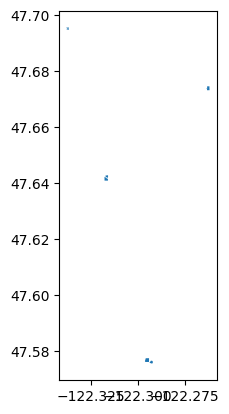

In [321]:
schoolSeattle[(schoolSeattle.element=='relation') & (schoolSeattle.geometry.geom_type=='MultiPolygon')].plot()

In [322]:
base=seattle.explore(tiles='cartodbpositron',color='lightblue')
schoolSeattle.explore(m=base,color='k')
fuelSeattle.explore(m=base,color='red')

# Explore proximity:


Let's compute a couple of distance matrices.

- The distance among fuel stations

In [323]:
D_Matrix_fuel_fuel=fuelSeattle.geometry.apply\
(lambda station: fuelSeattle.geometry.distance(station))

D_Matrix_fuel_fuel

newname,0_Magnolia Chevron,1_76,2_Arco,3_Chevron,4_Shell,5_7-Eleven,6_Unknown,7_Morrison's North Star Marine,8_Shilshole Fuel Dock,9_Dr. Dan's Biodiesel,...,119_Chevron,120_76,121_Chevron,122_Safeway Fuel Station,123_Shell,124_Unknown,125_Unknown,126_Shree's,127_7-Eleven,128_Unknown
newname,,,,,,,,,,,,,,,,,,,,,
0_Magnolia Chevron,0.000000,6189.778099,10273.929914,10832.142978,8458.219249,6096.362935,1421.466054,4154.629544,4607.185893,3684.919842,...,11032.720301,8059.083730,8471.490011,11342.071122,8388.488702,10264.595189,10273.665337,12839.472695,11229.479609,9704.676294
1_76,6189.778099,0.000000,5501.835964,12164.390410,5068.756372,4444.794018,5382.250509,2913.822486,9025.058016,5776.876534,...,10502.171854,9283.591945,5828.349523,6582.987118,3490.937461,5489.891699,5505.450023,10391.001557,7544.714281,5423.572544
2_Arco,10273.929914,5501.835964,0.000000,17647.977634,2412.958943,9905.007823,8983.111353,8274.383848,14091.627740,11081.482062,...,15762.599576,14783.917998,10878.789231,1108.751405,2040.456154,7.064947,3.934768,5845.860302,11751.992848,882.355032
3_Chevron,10832.142978,12164.390410,17647.977634,0.000000,17008.322965,7745.382606,11903.336160,9680.781667,6982.575734,7498.129000,...,3434.731016,2961.691541,7436.375075,18706.121900,15655.292108,17635.931517,17651.403425,22251.515513,8863.786937,17578.604974
4_Shell,8458.219249,5068.756372,2412.958943,17008.322965,0.000000,9427.806838,7082.172366,7342.660400,12635.016000,9933.327451,...,15557.714940,14059.287367,10879.733945,3206.070889,2163.657924,2410.063582,2406.309380,5325.665547,12298.163104,1528.265114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124_Unknown,10264.595189,5489.891699,7.064947,17635.931517,2410.063582,9892.946978,8974.271675,8262.798163,14080.867146,11070.121526,...,15750.545209,14771.940152,10866.803131,1112.002942,2028.966698,0.000000,9.738730,5851.112412,11739.062578,881.852025
125_Unknown,10273.665337,5505.450023,3.934768,17651.403425,2406.309380,9908.391095,8982.177405,8278.318057,14093.675362,11084.828567,...,15765.473717,14787.481689,10881.480990,1092.840243,2044.152170,9.738730,0.000000,5828.652504,11753.759841,873.716213
126_Shree's,12839.472695,10391.001557,5845.860302,22251.515513,5325.665547,14744.043923,11420.932493,12571.965336,17343.197545,14990.551645,...,20883.253836,19286.809328,16183.027772,5393.694936,7165.874001,5851.112412,5828.652504,0.000000,17427.534449,5304.377123


From here, we can compute the minimal distance among those gas stations:

In [324]:
D_Matrix_fuel_fuel.replace(0,None,inplace=True) # avoid the zero
D_Matrix_fuel_fuel.min(axis=1).sort_values().head(10)

,0
newname,
103_ARCO,3.577986
102_ARCO,3.577986
125_Unknown,3.934768
2_Arco,3.934768
88_76,4.467367
87_76,4.467367
124_Unknown,7.064947
89_Shell,10.521046
90_Shell,10.521046


- The distance among gas stations and schools:

In [338]:
Seattle_crs = "EPSG:26910"

fuelSeattle = fuelSeattle.to_crs(Seattle_crs)
schoolSeattle = schoolSeattle.to_crs(Seattle_crs)
D_Matrix_fuel_school=fuelSeattle.geometry.apply\
(lambda station: schoolSeattle.geometry.distance(station))

D_Matrix_fuel_school

newname,0_Mapleleaf School,1_Hazel Wolf K-8,2_Epic Life Academy,3_Christ the King Elementary School,4_Assumption Saint Bridget School,5_Saint Edward Parish School,6_Learning Way School,7_Concordia Lutheran School,8_Northwest Montessori School,9_Northwest Childrens Academy,...,200_Lincoln High School,201_Rainier Valley Leadership Academy,202_Eckstein Middle School,203_La Escuelita Bilingual School,204_Seattle Classical Christian School,205_Little Laurels,206_Cascade Parent Partnership Program,207_Roxhill Elementary School,208_Downtown School,209_Seattle Waldorf School - Main Campus
newname,,,,,,,,,,,,,,,,,,,,,
0_Magnolia Chevron,10491.659688,7199.084975,8539.173303,8956.657111,8932.523151,13341.958719,13507.709663,9506.260725,4487.653030,5324.737909,...,4977.718355,13761.296382,9053.687052,7195.602311,8098.316094,12230.115714,3124.787461,13580.295215,4054.694024,10282.565861
1_76,8685.624613,5789.863861,9049.451299,10124.534305,5853.770242,8808.620825,11975.722628,6599.617370,5074.222149,880.126226,...,4034.210699,9194.797832,6402.592462,6089.745057,2636.928658,10878.978200,3673.708903,12398.535914,2554.619356,8612.096410
2_Arco,13700.620054,11172.591200,14518.726558,15617.851005,10718.577863,3314.344802,7916.064925,11418.568474,10523.029481,6133.095742,...,9534.617245,3710.260832,11362.896436,11493.117725,2852.281509,15888.441265,8818.193919,8549.777900,6259.172443,13677.543840
3_Chevron,5687.981663,6575.805111,3142.833012,2065.133147,7921.183151,20929.652730,23474.696332,7563.706626,7465.701803,11654.725826,...,8017.156748,21301.486962,7045.990100,6198.145060,14759.706475,4983.299678,9477.043229,23725.977819,12427.156563,5446.866035
4_Shell,13742.500324,10822.941478,13957.036131,14944.971496,10856.827909,4930.152593,6965.257592,11596.129786,9605.655198,5388.607746,...,8836.404551,5347.980500,11437.825204,11106.714608,3118.349607,15939.807496,7649.546886,7450.088356,4780.314108,13675.664902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124_Unknown,13688.453602,11160.495810,14506.662453,15605.833039,10706.333066,3318.856997,7920.650189,11406.212850,10511.323734,6121.419610,...,9522.702465,3714.464240,11350.752366,11481.024512,2840.206268,15876.194727,8806.987948,8554.056002,6249.050996,13665.426959
125_Unknown,13703.171039,11175.769852,14522.099028,15621.341981,10721.070324,3298.233743,7899.875499,11420.972883,10526.881802,6136.969742,...,9538.270036,3694.529135,11365.463573,11496.333786,2855.613022,15890.932457,8821.174712,8534.101635,6260.101375,13680.130395
126_Shree's,19046.714482,16146.376840,19238.321146,20186.490665,16131.338043,4633.509651,2212.511637,16863.752907,14799.205507,10699.306284,...,14116.906307,4762.577365,16729.265591,16426.505984,8188.332056,21246.496324,12755.913237,2957.170911,9823.178035,18986.753055


# Decision 1: Find the stations that should go away



Now, we could compute the minimal distance from a gas station to a school, and sort the stations by that value:

In [339]:
fuelSeattle_proj = fuelSeattle.to_crs(epsg=32610)
schoolSeattle_proj = schoolSeattle.to_crs(epsg=32610)
D_Matrix_fuel_school.min(axis=1).sort_values().head(10)

,0
newname,
101_Shell,0.824760
37_Shell,23.258460
68_Shell,36.646314
1_76,75.072216
111_Chevron,91.233431
73_Shell,94.638676
109_Shell,97.053490
95_Chevron,100.006737
35_Chevron,112.051912


By the previous exploration, we may decide that no station should at 200 or less from a school:

In [340]:
mindDist=200

# Decision 2: Secure perimeter of every school

Let's create the safe area around the school. This requires **buffer**:

In [341]:
schoolSeattle_buffered=schoolSeattle.buffer(mindDist)
schoolSeattle_buffered

,0
newname,
0_Mapleleaf School,"POLYGON ((553125.436 5283350.335, 553124.473 5..."
1_Hazel Wolf K-8,"POLYGON ((551076.028 5280652.219, 551075.065 5..."
2_Epic Life Academy,"POLYGON ((549594.116 5283758.769, 549593.153 5..."
3_Christ the King Elementary School,"POLYGON ((548715.145 5284662.849, 548714.182 5..."
4_Assumption Saint Bridget School,"POLYGON ((553272.046 5280365.741, 553271.083 5..."
...,...
205_Little Laurels,"POLYGON ((552996.662 5285583.686, 552997.192 5..."
206_Cascade Parent Partnership Program,"POLYGON ((548097.853 5277444.55, 548200.996 52..."
207_Roxhill Elementary School,"POLYGON ((547208.545 5263118.173, 547211.211 5..."


In [344]:
#remember we have
type(schoolSeattle_buffered)

geopandas.geoseries.GeoSeries

Turning GS into GDF:

In [345]:
secured_schoolSeattle=gpd.GeoDataFrame(geometry=schoolSeattle_buffered)
secured_schoolSeattle

,geometry
newname,
0_Mapleleaf School,"POLYGON ((553125.436 5283350.335, 553124.473 5..."
1_Hazel Wolf K-8,"POLYGON ((551076.028 5280652.219, 551075.065 5..."
2_Epic Life Academy,"POLYGON ((549594.116 5283758.769, 549593.153 5..."
3_Christ the King Elementary School,"POLYGON ((548715.145 5284662.849, 548714.182 5..."
4_Assumption Saint Bridget School,"POLYGON ((553272.046 5280365.741, 553271.083 5..."
...,...
205_Little Laurels,"POLYGON ((552996.662 5285583.686, 552997.192 5..."
206_Cascade Parent Partnership Program,"POLYGON ((548097.853 5277444.55, 548200.996 52..."
207_Roxhill Elementary School,"POLYGON ((547208.545 5263118.173, 547211.211 5..."


Buffers created polygons:

In [346]:
secured_schoolSeattle.geometry.geom_type.value_counts()

,count
Polygon,210


# Decision 3: Standardized Gas stations geometries

Not all gas stations are points:

In [347]:
fuelSeattle.geometry.geom_type.value_counts()

,count
Polygon,114
Point,15


In [348]:
fuelSeattle = fuelSeattle.to_crs(Seattle_crs)
schoolSeattle = schoolSeattle.to_crs(Seattle_crs)

In [349]:
fuelSeattle_allPoly=fuelSeattle.copy()
fuelSeattle_allPoly['geometry'] = [
    station.buffer(10) if station.geom_type == 'Point' else station
    for station in fuelSeattle.geometry
]

In [350]:
# rechecking
fuelSeattle_allPoly.geometry.geom_type.value_counts()

,count
Polygon,129


# Decision 4: Overlay or SJoin to determine gas stations in trouble

This is great moment to test our understanding of these ops:

- do you want to move the points from the gas stations that are close to the schools?

In [351]:
fuelSeattle_allPoly.overlay(secured_schoolSeattle,how='intersection',keep_geom_type=False)

,element,geometry
0,node,"POLYGON ((551078.363 5274864.572, 551078.219 5..."
1,node,"POLYGON ((551078.363 5274864.572, 551078.219 5..."
2,node,"POLYGON ((552830.345 5269649.137, 552830.201 5..."
3,node,"POLYGON ((550424.799 5269838.128, 550424.655 5..."
4,node,"POLYGON ((553782.981 5266125.595, 553782.837 5..."
5,node,"POLYGON ((548171.127 5263444.827, 548170.983 5..."
6,way,"POLYGON ((549200.164 5283742.752, 549194.91 52..."
7,way,"POLYGON ((546272.901 5269904.828, 546264.427 5..."
8,way,"POLYGON ((552390.26 5272921.862, 552382.489 52..."
9,way,"POLYGON ((552390.26 5272921.862, 552382.489 52..."


- do you want to move the gas stations that are close to the schools?

In [352]:
fuelSeattle_allPoly.sjoin(secured_schoolSeattle,how='inner',predicate='intersects')

,element,geometry,newname_right
newname_left,,,
1_76,node,"POLYGON ((551078.412 5274865.552, 551078.363 5...",41_St. Nicholas School
1_76,node,"POLYGON ((551078.412 5274865.552, 551078.363 5...",147_Lowell Elementary School
2_Arco,node,"POLYGON ((552830.393 5269650.118, 552830.345 5...",54_Franklin High School
4_Shell,node,"POLYGON ((550424.847 5269839.108, 550424.799 5...",18_Career Link School
13_Chevron,node,"POLYGON ((553783.029 5266126.575, 553782.981 5...",163_Aki Kurose Middle School
14_Gas & Smoke Depot,node,"POLYGON ((548171.175 5263445.807, 548171.127 5...",6_Learning Way School
17_Arco,way,"POLYGON ((549199.723 5283761.099, 549200.164 5...",2_Epic Life Academy
19_Safeway,way,"POLYGON ((546272.699 5269920.842, 546272.901 5...",98_Lafayette Elementary School
23_Arco,way,"POLYGON ((552390.065 5272931.786, 552390.26 52...",76_Garfield High School


The obvious choice is using **sjoin** + **intersects** (why not within?).

In [353]:
gas_relocate=fuelSeattle_allPoly.sjoin(secured_schoolSeattle,how='inner',predicate='intersects')

It is possible the index may have duplicates:

In [354]:
is_duplicate = gas_relocate.index.duplicated(keep=False)

gas_relocate[is_duplicate]

,element,geometry,newname_right
newname_left,,,
1_76,node,"POLYGON ((551078.412 5274865.552, 551078.363 5...",41_St. Nicholas School
1_76,node,"POLYGON ((551078.412 5274865.552, 551078.363 5...",147_Lowell Elementary School
23_Arco,way,"POLYGON ((552390.065 5272931.786, 552390.26 52...",76_Garfield High School
23_Arco,way,"POLYGON ((552390.065 5272931.786, 552390.26 52...",181_Nova High School
68_Shell,way,"POLYGON ((551874.231 5273802.685, 551871.234 5...",192_Seattle World School
68_Shell,way,"POLYGON ((551874.231 5273802.685, 551871.234 5...",112_Morningside Academy
68_Shell,way,"POLYGON ((551874.231 5273802.685, 551871.234 5...",51_The Hatch School
71_7-Eleven,way,"POLYGON ((551684.055 5273748.468, 551690.484 5...",192_Seattle World School
71_7-Eleven,way,"POLYGON ((551684.055 5273748.468, 551690.484 5...",112_Morningside Academy


Remember our names are on the row index, then:

In [355]:
gas_relocate.reset_index(drop=False).\
drop_duplicates(subset='newname_left').\
set_index('newname_left')

,element,geometry,newname_right
newname_left,,,
1_76,node,"POLYGON ((551078.412 5274865.552, 551078.363 5...",41_St. Nicholas School
2_Arco,node,"POLYGON ((552830.393 5269650.118, 552830.345 5...",54_Franklin High School
4_Shell,node,"POLYGON ((550424.847 5269839.108, 550424.799 5...",18_Career Link School
13_Chevron,node,"POLYGON ((553783.029 5266126.575, 553782.981 5...",163_Aki Kurose Middle School
14_Gas & Smoke Depot,node,"POLYGON ((548171.175 5263445.807, 548171.127 5...",6_Learning Way School
17_Arco,way,"POLYGON ((549199.723 5283761.099, 549200.164 5...",2_Epic Life Academy
19_Safeway,way,"POLYGON ((546272.699 5269920.842, 546272.901 5...",98_Lafayette Elementary School
23_Arco,way,"POLYGON ((552390.065 5272931.786, 552390.26 52...",76_Garfield High School
29_7-Eleven,way,"POLYGON ((545947.294 5280203.279, 545947.259 5...",134_Adams Elementary School


In [356]:
#making the actual change
gas_relocate= gas_relocate.reset_index(drop=False).drop_duplicates(subset='newname_left').\
              set_index('newname_left')

Let's see both schools and those stations to relocate:

In [357]:
base=secured_schoolSeattle.sjoin(gas_relocate,how='inner',predicate='intersects').explore(color='yellow', tiles='cartodbpositron')
gas_relocate.explore(m=base,color='red')

# Decision 5: Find suitable places for the stations in trouble


We can not put the gas stations anywhere. They need to be situated on driveable routes, not inside a house or building.


- Find suitable locations along routes

Let's get the streets from Seattle with the help of OSM:

In [358]:
# Define the place
place = "Seattle, Washington, USA"

# Download the street network graph for Seattle
G = ox.graph_from_place(place, network_type="drive")

# Convert the graph edges (streets) to a GeoDataFrame
streets = ox.graph_to_gdfs(G, nodes=False, edges=True)

streets.shape

(50210, 15)

You see we got a huge set of routes:

In [359]:
streets.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 50210 entries, (np.int64(29445663), np.int64(335444348), np.int64(0)) to (np.int64(13246217556), np.int64(3705345449), np.int64(0))
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   osmid     50210 non-null  object  
 1   highway   50210 non-null  object  
 2   lanes     38684 non-null  object  
 3   maxspeed  49841 non-null  object  
 4   oneway    50210 non-null  bool    
 5   ref       756 non-null    object  
 6   reversed  50210 non-null  object  
 7   length    50210 non-null  float64 
 8   geometry  50210 non-null  geometry
 9   bridge    470 non-null    object  
 10  name      44823 non-null  object  
 11  tunnel    60 non-null     object  
 12  junction  4752 non-null   object  
 13  access    166 non-null    object  
 14  width     269 non-null    object  
dtypes: bool(1), float64(1), geometry(1), object(12)
memory usage: 6.9+ MB


Let's pay attention to the 'highway' column:

In [360]:
streets.highway.value_counts().index

Index([                   'residential',                       'tertiary',
                            'secondary',                        'primary',
                         'unclassified',                  'motorway_link',
                             'motorway',                 'secondary_link',
                                'trunk',                   'primary_link',
                        'tertiary_link',                  'living_street',
        ['unclassified', 'residential'],                     'trunk_link',
                               'busway', ['residential', 'living_street'],
            ['residential', 'tertiary'],     ['unclassified', 'tertiary'],
              ['tertiary', 'secondary'],        ['secondary', 'tertiary'],
          ['motorway_link', 'motorway'],     ['motorway_link', 'primary'],
             ['trunk_link', 'tertiary'],         ['secondary', 'primary'],
               ['primary', 'secondary'],      ['trunk_link', 'secondary'],
          ['trunk_link', 

In [361]:
GAS_STATION_ROAD_TYPES = [
    'motorway',      # High-speed limited access roads
    'primary',       # Major national roads
    'trunk',         # Important regional roads
    'motorway_link', # Motorway entrance/exit ramps
    'primary_link',  # Primary road connectors
    'trunk_link',     # Trunk road connectors
    ['motorway', 'trunk'],
    ['primary', 'motorway_link'],
    ['primary', 'primary_link']
]

suitable_roads = streets[streets.highway.isin(GAS_STATION_ROAD_TYPES)]

suitable_roads.shape

(2427, 15)

Let's reproject:

In [362]:
suitable_roads = suitable_roads.to_crs(seattle.crs)

In [363]:
competitionDistance=200 # a safe value from above 'D_Matrix_fuel_fuel'
fuelSeattle_allPoly_buffered=fuelSeattle_allPoly.buffer(competitionDistance)

Do we have a GDF?

In [364]:
type(fuelSeattle_allPoly_buffered)

geopandas.geoseries.GeoSeries

In [365]:
secured_fuelSeattle_allPoly=gpd.GeoDataFrame(geometry=fuelSeattle_allPoly_buffered)


Let's combine the secured areas:



In [366]:
secured_areas_dissolved=secured_fuelSeattle_allPoly.overlay(secured_schoolSeattle,how='union',keep_geom_type=False).dissolve()
secured_areas=gpd.GeoDataFrame(geometry=secured_areas_dissolved.geometry)

- Filter the roads. We can NOT choose a location that intersects with the secured areas:

Choose: **overlay** vs **sjoin** vs **clip**?

<Axes: >

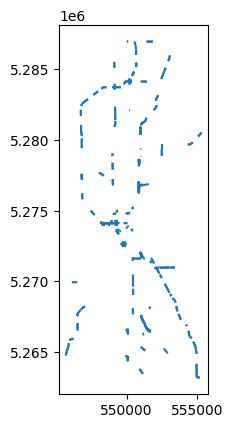

In [367]:
suitable_roads = suitable_roads.to_crs(Seattle_crs)
secured_areas = secured_areas.to_crs(Seattle_crs)
suitable_roads.clip(secured_areas,keep_geom_type=False).plot()

<Axes: >

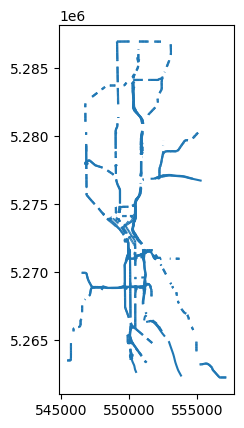

In [368]:
suitable_roads.overlay(secured_areas,keep_geom_type=False, how='difference').plot()

<Axes: >

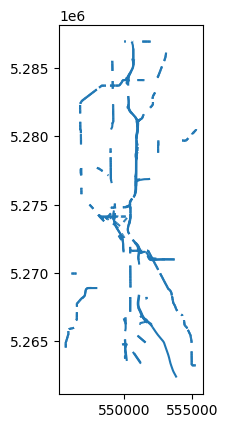

In [369]:
secured_areas = secured_areas.to_crs(Seattle_crs)
suitable_roads = suitable_roads.to_crs(Seattle_crs)
suitable_roads.sjoin(secured_areas, predicate='intersects').plot()

In [370]:
good_routes_forGas_dissolved=suitable_roads.overlay(secured_areas,keep_geom_type=False, how='difference').dissolve()
good_routes_forGas=gpd.GeoDataFrame(geometry=good_routes_forGas_dissolved.geometry)
good_routes_forGas

,geometry
0,"MULTILINESTRING ((551005.266 5276760.855, 5510..."


<Axes: >

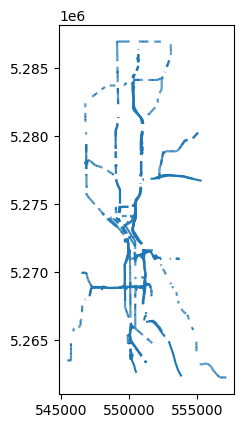

In [371]:
good_routes_forGas.plot()

We may choose a location from those places:

In [372]:
# newCOMPETITORS=safe_fuelCompetitors_gdf.copy()
potential_Locations=good_routes_forGas.copy()
newPOLYGONS=[]
pointsComputed=1
attempts=1
while pointsComputed<=len(gas_relocate):
  candidatePoint=potential_Locations.sample_points(1)
  candidateStation=gpd.GeoDataFrame(geometry=candidatePoint.buffer(200))
  if candidateStation.overlay(secured_areas,how='intersection',keep_geom_type=False).empty:
    newPOLYGONS.append(candidateStation)
    pointsComputed+=1
    potential_Locations=potential_Locations.overlay(candidateStation, how='difference', keep_geom_type=False)
  if attempts>len(gas_relocate)*10:
    break
  attempts+=1

# some info
attempts,len(newPOLYGONS)



(53, 28)

In [373]:
newPOLYGONS

[                                            geometry
 0  POLYGON ((549512.269 5275588.742, 549511.306 5...,
                                             geometry
 0  POLYGON ((551010.494 5268893.671, 551009.531 5...,
                                             geometry
 0  POLYGON ((547039.5 5278196.549, 547038.537 527...,
                                             geometry
 0  POLYGON ((547547.604 5277981.571, 547546.641 5...,
                                             geometry
 0  POLYGON ((551286.261 5270865.21, 551285.298 52...,
                                             geometry
 0  POLYGON ((551239.68 5268811.563, 551238.717 52...,
                                             geometry
 0  POLYGON ((549364.733 5283194.952, 549363.77 52...,
                                             geometry
 0  POLYGON ((549071.238 5268833.262, 549070.275 5...,
                                             geometry
 0  POLYGON ((550481.502 5273039.487, 550480.539 5...,
                   

In [374]:
pd.concat(newPOLYGONS)

,geometry
0,"POLYGON ((549512.269 5275588.742, 549511.306 5..."
0,"POLYGON ((551010.494 5268893.671, 551009.531 5..."
0,"POLYGON ((547039.5 5278196.549, 547038.537 527..."
0,"POLYGON ((547547.604 5277981.571, 547546.641 5..."
0,"POLYGON ((551286.261 5270865.21, 551285.298 52..."
0,"POLYGON ((551239.68 5268811.563, 551238.717 52..."
0,"POLYGON ((549364.733 5283194.952, 549363.77 52..."
0,"POLYGON ((549071.238 5268833.262, 549070.275 5..."
0,"POLYGON ((550481.502 5273039.487, 550480.539 5..."
0,"POLYGON ((551229.493 5271251.106, 551228.53 52..."


In [375]:
GoodLocationsGas_buffered_gdf=pd.concat(newPOLYGONS)
GoodLocationsGas_gdf=gpd.GeoDataFrame(geometry=GoodLocationsGas_buffered_gdf.centroid)

<Axes: >

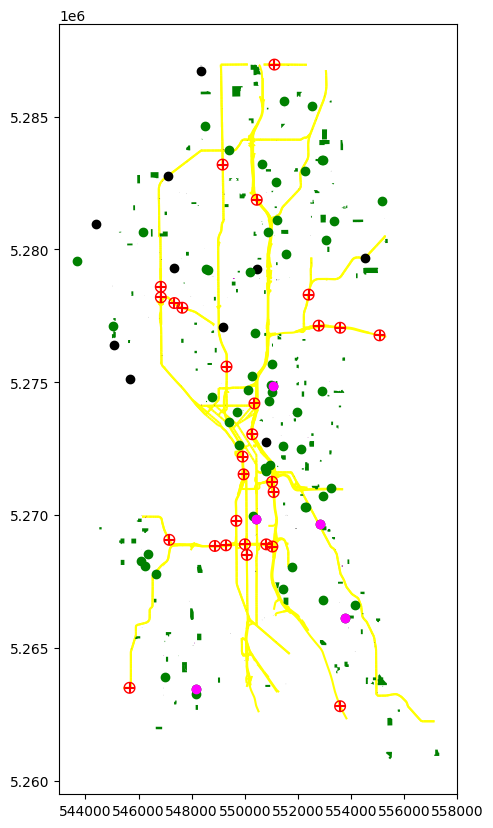

In [376]:
# original suitable roads
base = suitable_roads.plot(color='yellow', figsize=(10, 10),zorder=1)

# non-overlapping buffers
GoodLocationsGas_buffered_gdf.plot(ax=base, edgecolor='red', marker="+", facecolor='none',zorder=2)

# center points of the buffers
GoodLocationsGas_gdf.plot(ax=base, color='red', marker="+", markersize=50,zorder=3)

# all stations
fuelSeattle.plot(ax=base,color='k',zorder=4)
schoolSeattle.plot(ax=base,color='green',zorder=5)

# stations to relocate
fuelSeattle.clip(gas_relocate).plot(ax=base,color='magenta',zorder=5)


## Reverse geocoding

Just get some addresses:

In [377]:
from geopy.geocoders import Nominatim
import time

# Initialize geocoder
geolocator = Nominatim(user_agent="seattle_gas_stations")

def get_address(point):
  # Now coordinates are in degrees (lon, lat)
  lon = point.x
  lat = point.y
  location = geolocator.reverse((point.y, point.x), exactly_one=True, timeout=10)
  time.sleep(1)  # Rate limiting

  if location:
    return location.address
  else:
    return None # not found

In [378]:
# Getting addresses
GoodLocationsGas_4326 = GoodLocationsGas_gdf.to_crs('EPSG:4326')
GoodLocationsGas_gdf['address'] = GoodLocationsGas_4326.geometry.apply(get_address)

In [294]:
GoodLocationsGas_gdf

,geometry,address
0,POINT (550076.862 5268691.762),"3800, 1st Avenue South, Seattle, King County, ..."
0,POINT (550778.445 5264031.322),"West Marginal Way South, South Park, Seattle, ..."
0,POINT (552423.138 5278399.799),"University of Washington, Mary Gates Memorial ..."
0,POINT (549720.955 5270675.707),"State Route 99, Yesler Terrace, Seattle, King ..."
0,POINT (549188.668 5268840.519),"West Seattle Bridge, Youngstown, Seattle, King..."
0,POINT (548760.809 5268832.077),"West Seattle Bridge, Youngstown, Seattle, King..."
0,POINT (551213.753 5268982.264),"West Seattle Bridge, Beacon Hill, Seattle, Kin..."
0,POINT (550442.871 5270918.498),"1501, 4th Avenue South, Yesler Terrace, Seattl..."
0,POINT (552468.102 5277045.144),"WA 520, Montlake, Seattle, King County, Washin..."
0,POINT (550077.29 5265467.809),"West Marginal Way South, Georgetown, Seattle, ..."


# Conclusion

Based on the analysis:

- We identified gas stations located within a 200-meter buffer zone around schools.
- We determined suitable road types for gas stations and filtered the road network accordingly.
- We found potential relocation sites along the suitable roads that are outside the secured buffer zones around schools and other gas stations.
- We obtained the addresses for these potential new locations using reverse geocoding.

This analysis provides a data-driven approach to inform decisions about relocating gas stations to improve safety and minimize proximity to schools. Further analysis could involve considering other factors such as zoning regulations, traffic flow, and community impact.

______

[BACK TO MAIN MENU](https://cienciadedatosespacial.github.io/GDF_OPS_applications/)